In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import gc
from keras_tuner import BayesianOptimization
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from keras_tuner.engine.hyperparameters import HyperParameters

# Utils

In [3]:
# plot training history function
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Thesis/RWF-2000.zip -d /content

DIR_PATH = "./RWF-2000"
TRAIN_DIR = os.path.join(DIR_PATH, "train")
TEST_DIR = os.path.join(DIR_PATH, "val")

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Thesis/RWF-2000.zip
   creating: /content/RWF-2000/
   creating: /content/RWF-2000/train/
   creating: /content/RWF-2000/train/Fight/
  inflating: /content/RWF-2000/train/Fight/train_Fight (1).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (10).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (100).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (101).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (102).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (103).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (104).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (105).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (106).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (107).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (108).avi  
  inflating: /content/RWF-2000/train/Fight/train_Fight (109).avi  
  infl

In [5]:
CLASS_NAMES = os.listdir(TRAIN_DIR)
SEED = 1337
BATCH_SIZE = 10

ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

## Load Data

In [6]:
# get list of labels and video path
def get_labels_and_video_paths(data_dir):
    labels = []
    video_paths = []
    for label in CLASS_NAMES:
        label_dir = os.path.join(data_dir, label)
        for video in os.listdir(label_dir):
            video_paths.append(os.path.join(label_dir, video))
            labels.append(label)
    return labels, video_paths

In [7]:
import gc

def load_videos(video_IDs: list, video_labels: dict, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    labels = np.empty((len(video_IDs),), dtype=np.int8)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)
        labels[i] = video_labels[video_ID]

    return videos, labels

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        bacth_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]

        return load_videos(bacth_IDs, self.video_labels, self.video_frames, self.video_width, self.video_height, self.video_channels, self.dtype, self.normalize)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

In [8]:
import glob

train_video_IDs = glob.glob(f"{DIR_PATH}/train/*/*")
train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_IDs = glob.glob(f"{DIR_PATH}/val/*/*")
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}

train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=BATCH_SIZE)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=BATCH_SIZE)

# Training Model

In [9]:
@keras.utils.register_keras_serializable(package="FrameDifference")
class FrameDifference(layers.Layer):
    def __init__(self, **kwargs):
        super(FrameDifference, self).__init__(**kwargs)

    def call(self, video):
        return video[:, 1:] - video[:, :-1]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] - 1) + input_shape[2:]

In [10]:
@keras.utils.register_keras_serializable(package="MotionBlur")
class MotionBlur(layers.Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(MotionBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.kernel = tf.constant([[1.0 / self.kernel_size] * self.kernel_size], dtype=tf.float32)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.tile(self.kernel, [1, 1, input_shape[-1], 1])

    def call(self, inputs):
        return tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

@keras.utils.register_keras_serializable(package="HistogramEqualizatoin")
class HistogramEqualizationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HistogramEqualizationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Apply histogram equalization on each frame in the batch
        equalized_images = tf.map_fn(self.equalize_frame, inputs, dtype=tf.float32)
        return equalized_images

    def equalize_frame(self, frame):
        # Convert each frame to numpy and apply histogram equalization with OpenCV
        equalized_frame = tf.numpy_function(self.apply_cv2_equalize, [frame], tf.float32)
        return equalized_frame

    def apply_cv2_equalize(self, frame):
        frame = frame.numpy()  # Convert to numpy if needed
        frame = np.clip(frame, 0, 1) * 255.0  # Scale to 0-255 range for cv2 compatibility
        frame = frame.astype(np.uint8)

        # Check if the frame is grayscale or color
        if frame.shape[-1] == 1:
            # Grayscale image
            equalized_frame = cv2.equalizeHist(frame.squeeze()).reshape(frame.shape)
        else:
            # Color image (apply equalization to each channel separately)
            channels = cv2.split(frame)
            equalized_channels = [cv2.equalizeHist(channel) for channel in channels]
            equalized_frame = cv2.merge(equalized_channels)

        # Convert back to float32 and normalize to [0, 1]
        equalized_frame = equalized_frame.astype(np.float32) / 255.0
        return equalized_frame

    def compute_output_shape(self, input_shape):
        return input_shape


In [11]:
def create_model(hp):
    # Input layer
    inputs = layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

    # Add Gaussian Noise
    x = layers.GaussianNoise(0.1)(inputs)
    
    # Add Histogram Equalization
    x = layers.TimeDistributed(layers.Lambda(lambda frame: tf.image.equalize_histogram(frame)))(x)

    # Add Motion Blur
    x = layers.TimeDistributed(MotionBlur(kernel_size=5))(x)

    # Apply Frame Difference using the custom layer
    x = FrameDifference()(x)

    # ConvLSTM2D block 1
    x = layers.ConvLSTM2D(
        filters=4,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        recurrent_dropout=hp.Float('recurrent_dropout_1', min_value=0.0, max_value=0.5, step=0.1),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        data_format='channels_last'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = layers.TimeDistributed(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))(x)

    # ConvLSTM2D block 2
    x = layers.ConvLSTM2D(
        filters=8,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        recurrent_dropout=hp.Float('recurrent_dropout_2', min_value=0.0, max_value=0.5, step=0.1),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        data_format='channels_last'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = layers.TimeDistributed(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))(x)

    # ConvLSTM2D block 3
    x = layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False,
        recurrent_dropout=hp.Float('recurrent_dropout_3', min_value=0.0, max_value=0.5, step=0.1),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        data_format='channels_last'
    )(x)
    x = layers.BatchNormalization()(x)

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(data_format='channels_last')(x)

    # Fully Connected Dense Layers
    x = layers.Dense(units=128, activation='relu')(x)
    x = layers.Dense(units=16, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    # Define and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw'])
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = AdamW(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
PROJECT_NAME = "violence_detection_fine_tuning_2"
EXPERIMENT_NAME = 'frame_diff_and_motion_blur_fine_tuning_2'
PATH_TUNING = f"/content/drive/MyDrive/Thesis/{EXPERIMENT_NAME}/tuning"
PATH_CHECKPOINT = f"/content/drive/MyDrive/Thesis/{EXPERIMENT_NAME}/best_model_{EXPERIMENT_NAME}.keras"

In [13]:
# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=PATH_CHECKPOINT,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 verbose=1)

In [14]:
EPOCH = 40

In [15]:
import keras_tuner as kt

# Instantiate the tuner
tuner = kt.BayesianOptimization(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    directory=PATH_TUNING,
    project_name=PROJECT_NAME
)

# Run the search
tuner.search(
    train_generator,
    epochs=EPOCH, validation_data=test_generator, batch_size=BATCH_SIZE, callbacks=[lr_scheduler, early_stopping])

Reloading Tuner from /content/drive/MyDrive/Thesis/frame_diff_and_motion_blur_fine_tuning_2/tuning/violence_detection_fine_tuning_2/tuner0.json


In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'recurrent_dropout_1': 0.4, 'dropout_1': 0.2, 'recurrent_dropout_2': 0.0, 'dropout_2': 0.30000000000000004, 'recurrent_dropout_3': 0.0, 'optimizer': 'adamw', 'learning_rate': 0.00022073259922153688}


In [17]:
# train the model
best_model = tuner.hypermodel.build(best_hps)

train_hist = best_model.fit(train_generator, validation_data=test_generator, epochs=EPOCH, batch_size = BATCH_SIZE, callbacks=[lr_scheduler, cp_callback])

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5170 - loss: 0.9200
Epoch 1: val_accuracy improved from -inf to 0.33250, saving model to /content/drive/MyDrive/Thesis/frame_diff_and_motion_blur_fine_tuning_2/best_model_frame_diff_and_motion_blur_fine_tuning_2.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.5173 - loss: 0.9198 - val_accuracy: 0.3325 - val_loss: 0.8382 - learning_rate: 2.2073e-04
Epoch 2/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5938 - loss: 0.7961
Epoch 2: val_accuracy improved from 0.33250 to 0.68750, saving model to /content/drive/MyDrive/Thesis/frame_diff_and_motion_blur_fine_tuning_2/best_model_frame_diff_and_motion_blur_fine_tuning_2.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.5942 - loss: 0.7958 - val_accuracy: 0.6875 - val_loss: 0.6729 - learning_rate: 2.2073e-04
Epoch 3/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7196 - loss: 0.6548
Epoch 3: val_accuracy improved from 0.68750 to 0.77500, saving mo

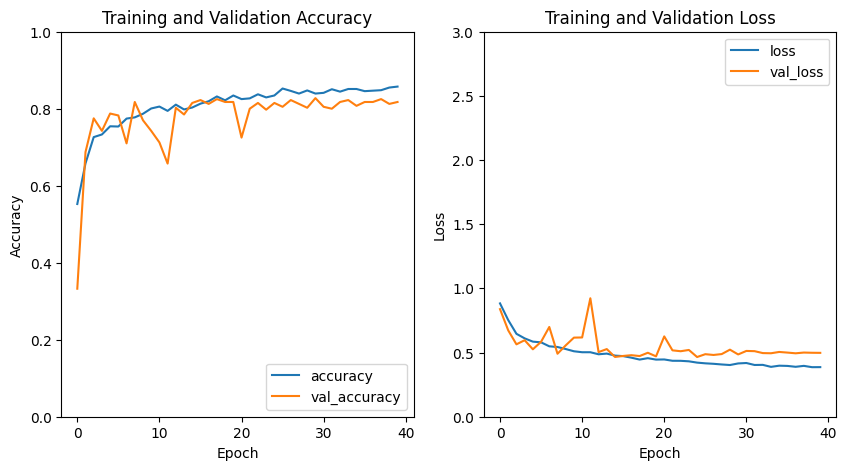

In [18]:
plot_training_history(train_hist)

# Evaluate

In [20]:
model_eval = tf.keras.models.load_model(PATH_CHECKPOINT)

In [23]:
test_loss, test_acc = model_eval.evaluate(test_generator, verbose=0)

print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")

Test Accuracy: 0.860
Test Loss: 0.485
